## Installing and Importing Packages 

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
!pip install stable-baselines3[extra] protobuf==3.20.*

In [3]:
!pip install mss pydirectinput pytesseract

In [4]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
from matplotlib import pyplot as plt
import time
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Box, Discrete 

## Creating the Environment 

In [124]:
class WebGame(Env):
    
    # initializes the env
    def __init__(self):
        super().__init__()
        # observations will be collected through images
        self.observation_space = Box(low=0, high=255, shape=(1, 83, 100), dtype=np.uint8)
        # the frog can either jump or do nothing
        self.action_space = Discrete(2) 
        
        # defines where to take the screenshots for observations
        self.cap = mss()
        self.game_location = {"top": 1100, "left": 100, "width": 600, "height": 400}
        self.done_location = {"top": 700, "left": 600, "width": 700, "height": 100}
    
    # defines how the agent plays the game
    def step(self, action):
        action_dict = { 0: "space", 1: "no_op"}
        
        if action != 1:
            pydirectinput.press(action_dict[action])
            
        done, done_screen_cap = self.get_done()
        new_observation = self.get_observation()
        reward = 1
        info = {}
        
        return new_observation, reward, done, False, info
    
    # shows the observation taken in another window
    def render(self):
        cv2.imshow("Game", np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord("q"):
            self.close()
    
    # grabs a new observation and resets the game
    def reset(self, seed=None):
        time.sleep(1)
        pydirectinput.click(x=900, y=950)
        pydirectinput.press("space")
        return self.get_observation()
    
    def close(self):
        cv2.destroyAllWindows()
    
    # define preprocessing for observations
    def get_observation(self):
        # we want the all of the width, all of the height, and only the first 3 channels since our 
        # observations are images
        screen_cap = np.array(self.cap.grab(self.game_location))[:,:,:3]
        gray_scale = cv2.cvtColor(screen_cap, cv2.COLOR_BGR2GRAY)
        # resize observations to match action space of env
        pic_resized = cv2.resize(gray_scale, (100, 83))
        channel = np.reshape(pic_resized, (1, 83, 100))
        return channel
    
    # determines the end of an episode (game round) through OCR
    def get_done(self):
        # we want the all of the width, all of the height, and only the first 3 channels since our 
        # observations are images
        done_screen_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        done_strings = ['GAME', 'GAHE', 'GANH', 'GANE', "_ om "]
        done = False
        # only checking the first 4 letters of the game over screen
        res = pytesseract.image_to_string(done_screen_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_screen_cap
    

# Testing the Environment

In [125]:
env = WebGame()

In [74]:
obs = env.get_observation()

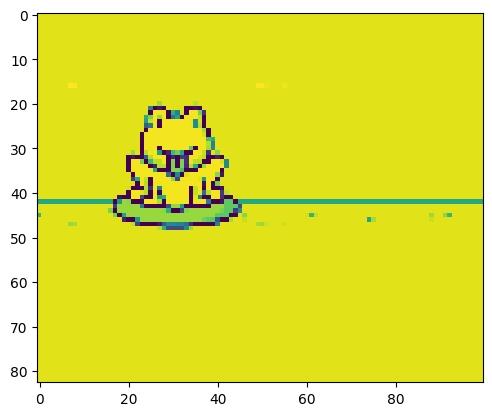

In [75]:
plt.imshow(obs[0])

True


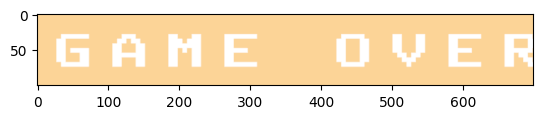

In [19]:
done, done_cap = env.get_done()
print(done)
plt.imshow(done_cap)

In [533]:
env.reset()

array([[[198, 198, 198, ..., 198, 198, 198],
        [198, 198, 198, ..., 198, 198, 198],
        [198, 198, 198, ..., 198, 198, 198],
        ...,
        [198, 198, 198, ..., 198, 198, 198],
        [198, 198, 198, ..., 198, 198, 198],
        [198, 198, 198, ..., 198, 198, 198]]], dtype=uint8)

In [534]:
# sample run with random observations
for episode in range(10):  
    obs = env.reset()
    done = False
    total_reward = 0
       
    while not done:
        obs, reward, done, info = env.step(env.action_space.sample())
        total_reward += reward            
    print(f"Total Reward for episode number {episode} is {total_reward}")

Total Reward for episode number 0 is 11
Total Reward for episode number 1 is 15
Total Reward for episode number 2 is 14
Total Reward for episode number 3 is 16
Total Reward for episode number 4 is 11
Total Reward for episode number 5 is 10
Total Reward for episode number 6 is 7
Total Reward for episode number 7 is 25
Total Reward for episode number 8 is 17
Total Reward for episode number 9 is 21


# Training the Model 

In [44]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

In [45]:
# checks env to see if valid
env_checker.check_env(env)

In [102]:
# every specified time steps, the model with the best results in playing the game will be saved
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    
    def __init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
    
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, "best_model")
            self.model.save(model_path)
        return True

In [119]:
# paths to save models and tensorboards
CHECKPOINT_DIR = "C:/Users/mitra/OneDrive/Documents/Personal_Projects/Train"
LOG_DIR = "C:/Users/mitra/OneDrive/Documents/Personal_Projects/Logs"

In [120]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [105]:
from stable_baselines3 import DQN

In [121]:
# initializing the model
model = DQN(
    "CnnPolicy", 
    env, 
    tensorboard_log=LOG_DIR, 
    verbose=1, 
    buffer_size=300000, 
    learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [122]:
model.learn(total_timesteps=20000, callback=callback)

Logging to C:/Users/mitra/OneDrive/Documents/Personal_Projects/Logs\DQN_6
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13       |
|    ep_rew_mean      | 13       |
|    exploration_rate | 0.975    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 27       |
|    total_timesteps  | 52       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.5     |
|    ep_rew_mean      | 15.5     |
|    exploration_rate | 0.941    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2        |
|    time_elapsed     | 61       |
|    total_timesteps  | 124      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 15.4     |
|    ep_rew_mean      | 15.4     |
|    exploration

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.2     |
|    ep_rew_mean      | 16.2     |
|    exploration_rate | 0.353    |
| time/               |          |
|    episodes         | 84       |
|    fps              | 2        |
|    time_elapsed     | 649      |
|    total_timesteps  | 1363     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00019  |
|    n_updates        | 90       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 16.2     |
|    ep_rew_mean      | 16.2     |
|    exploration_rate | 0.325    |
| time/               |          |
|    episodes         | 88       |
|    fps              | 2        |
|    time_elapsed     | 683      |
|    total_timesteps  | 1422     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00017  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.1     |
|    ep_rew_mean      | 25.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 148      |
|    fps              | 2        |
|    time_elapsed     | 1539     |
|    total_timesteps  | 3258     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.82e-05 |
|    n_updates        | 564      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 25.4     |
|    ep_rew_mean      | 25.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 152      |
|    fps              | 2        |
|    time_elapsed     | 1601     |
|    total_timesteps  | 3391     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 2.47e-06 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 35.9     |
|    ep_rew_mean      | 35.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 212      |
|    fps              | 2        |
|    time_elapsed     | 2531     |
|    total_timesteps  | 5430     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.18e-05 |
|    n_updates        | 1107     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | 37.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 216      |
|    fps              | 2        |
|    time_elapsed     | 2622     |
|    total_timesteps  | 5623     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.4e-05  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.6     |
|    ep_rew_mean      | 39.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 276      |
|    fps              | 2        |
|    time_elapsed     | 3702     |
|    total_timesteps  | 8075     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.47e-05 |
|    n_updates        | 1768     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 39.1     |
|    ep_rew_mean      | 39.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 280      |
|    fps              | 2        |
|    time_elapsed     | 3752     |
|    total_timesteps  | 8175     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.42e-05 |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.7     |
|    ep_rew_mean      | 38.7     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 340      |
|    fps              | 2        |
|    time_elapsed     | 4719     |
|    total_timesteps  | 10361    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0178   |
|    n_updates        | 2340     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 37.4     |
|    ep_rew_mean      | 37.4     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 344      |
|    fps              | 2        |
|    time_elapsed     | 4748     |
|    total_timesteps  | 10427    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0157   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21.9     |
|    ep_rew_mean      | 21.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 404      |
|    fps              | 2        |
|    time_elapsed     | 5376     |
|    total_timesteps  | 11793    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00107  |
|    n_updates        | 2698     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 23.1     |
|    ep_rew_mean      | 23.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 408      |
|    fps              | 2        |
|    time_elapsed     | 5464     |
|    total_timesteps  | 12009    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00894  |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 36.8     |
|    ep_rew_mean      | 36.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 468      |
|    fps              | 2        |
|    time_elapsed     | 6510     |
|    total_timesteps  | 14539    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0229   |
|    n_updates        | 3384     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.3     |
|    ep_rew_mean      | 38.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 472      |
|    fps              | 2        |
|    time_elapsed     | 6582     |
|    total_timesteps  | 14717    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0174   |
|    n_updates      

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 47.3     |
|    ep_rew_mean      | 47.3     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 532      |
|    fps              | 2        |
|    time_elapsed     | 7869     |
|    total_timesteps  | 17672    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00547  |
|    n_updates        | 4167     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 46.9     |
|    ep_rew_mean      | 46.9     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 536      |
|    fps              | 2        |
|    time_elapsed     | 7934     |
|    total_timesteps  | 17825    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0177   |
|    n_updates      

# Playing the Game

In [126]:
# loads trained model from file system and plays game based on current state of observations
model = DQN.load("C:/Users/mitra/OneDrive/Documents/Personal_Projects/Train/best_model.zip")

In [127]:
for episode in range(10):
    obs = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action,_ = model.predict(obs)
        obs, reward, done, truncated, info = env.step(int(action))
        total_reward += reward
    print(f"Total Reward for episode number {episode}: {total_reward}")

Total Reward for episode number 0: 8
Total Reward for episode number 1: 26
Total Reward for episode number 2: 20
Total Reward for episode number 3: 6
Total Reward for episode number 4: 6
Total Reward for episode number 5: 12
Total Reward for episode number 6: 14
Total Reward for episode number 7: 15
Total Reward for episode number 8: 7
Total Reward for episode number 9: 96
